# 🛍 Online Retail Dataset — Data Visualisation
This notebook covers:
- Data loading from cleaned dataset
- Create supportive columns
- Show discriptive statistics
- Daily sales over time graph
- Monthly sales over time graph
- Customer segments graph
- Top 10 Customers by Quantity Purchased
- Top 10 popular products graph

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import datetime as dt
import plotly.express as px

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')


In [60]:
# Load cleaned dataset
df = pd.read_csv("..\\Resources\\Online_Retail_Clean.csv")

# Data type optimization
df['InvoiceNo'] = df['InvoiceNo'].astype('category')
df['StockCode'] = df['StockCode'].astype('category')
df['Description'] = df['Description'].astype('category')
df['Quantity'] = df['Quantity'].astype('int32')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['UnitPrice'] = df['UnitPrice'].astype('float32')
df['CustomerID'] = df['CustomerID'].astype('category')
df['Country'] = df['Country'].astype('category')

# Extract Year, Month, Day, Weekday
df['Year'] = df['InvoiceDate'].dt.year.astype('int16')
df['Month'] = df['InvoiceDate'].dt.month.astype('int8')
df['MonthName'] = df['InvoiceDate'].dt.strftime('%b').astype('category')
df['Day'] = df['InvoiceDate'].dt.day.astype('int8')
df['Weekday'] = df['InvoiceDate'].dt.day_name().astype('category')

# Calculate total sales per transaction
df['TotalSales'] = df['Quantity'] * df['UnitPrice']

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,MonthName,Day,Weekday,TotalSales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010,12,Dec,1,Wednesday,15.300000
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,Dec,1,Wednesday,20.340001
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010,12,Dec,1,Wednesday,22.000000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,Dec,1,Wednesday,20.340001
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,Dec,1,Wednesday,20.340001


In [61]:
# Descriptive statistics
total_sales = df['TotalSales'].sum()
num_customers = df['CustomerID'].nunique()
num_invoices = df['InvoiceNo'].nunique()
num_products = df['StockCode'].nunique()
avg_transaction_value = total_sales / num_invoices

print("📊 Descriptive Statistics:")
print(f"Total Sales: £{total_sales:,.2f}")
print(f"Number of Unique Customers: {num_customers}")
print(f"Number of Unique Invoices: {num_invoices}")
print(f"Number of Unique Products: {num_products}")
print(f"Average Transaction Value: £{avg_transaction_value:,.2f}")


📊 Descriptive Statistics:
Total Sales: £9,464,592.85
Number of Unique Customers: 4372
Number of Unique Invoices: 25754
Number of Unique Products: 4069
Average Transaction Value: £367.50


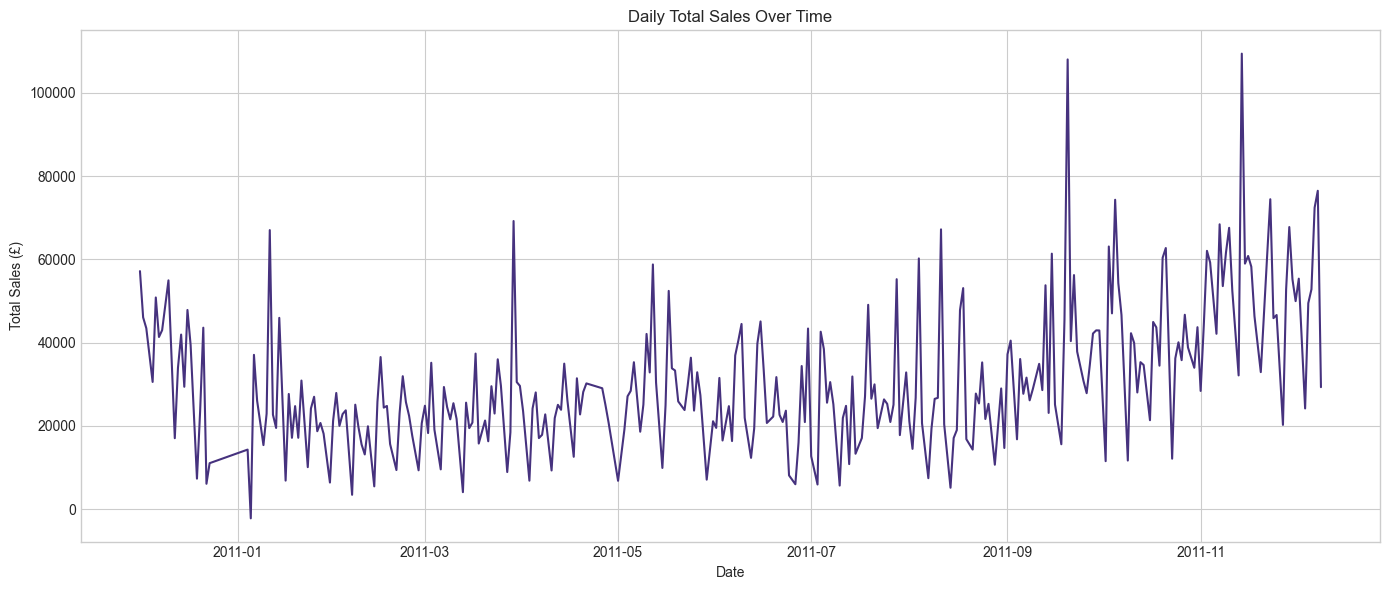

In [62]:
# Daily sales
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['TotalSales'].sum().reset_index()
daily_sales['InvoiceDate'] = pd.to_datetime(daily_sales['InvoiceDate'])

plt.figure(figsize=(14,6))
sns.lineplot(data=daily_sales, x='InvoiceDate', y='TotalSales')
plt.title('Daily Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales (£)')
plt.tight_layout()
plt.show()


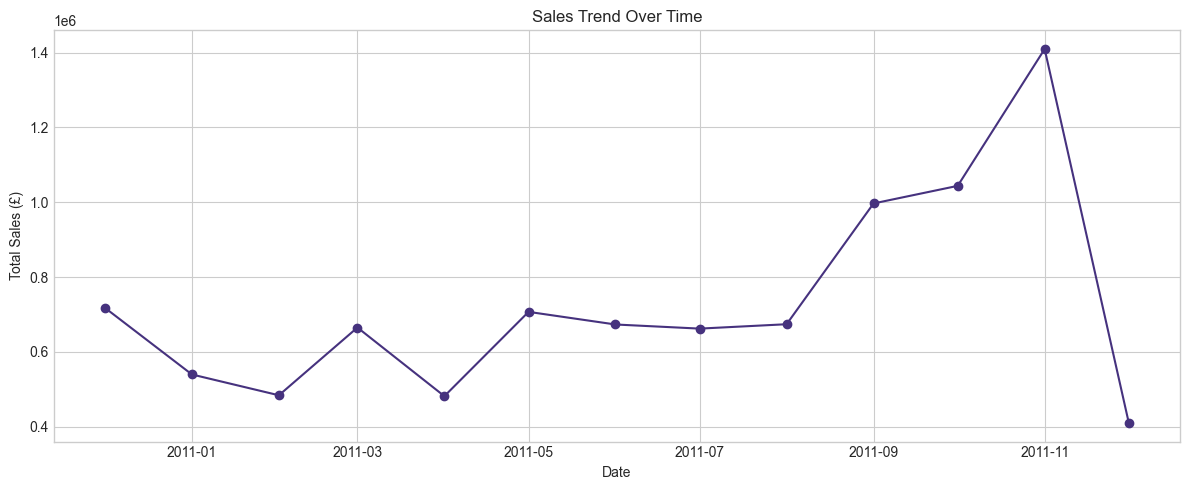

In [63]:
sales_trend = df.groupby(['Year', 'Month'])['TotalSales'].sum().reset_index()
sales_trend['YearMonth'] = pd.to_datetime(sales_trend['Year'].astype(str) + '-' + sales_trend['Month'].astype(str))

plt.figure(figsize=(12,5))
plt.plot(sales_trend['YearMonth'], sales_trend['TotalSales'], marker='o')
plt.title('Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales (£)')
plt.grid(True)
plt.tight_layout()
plt.show()


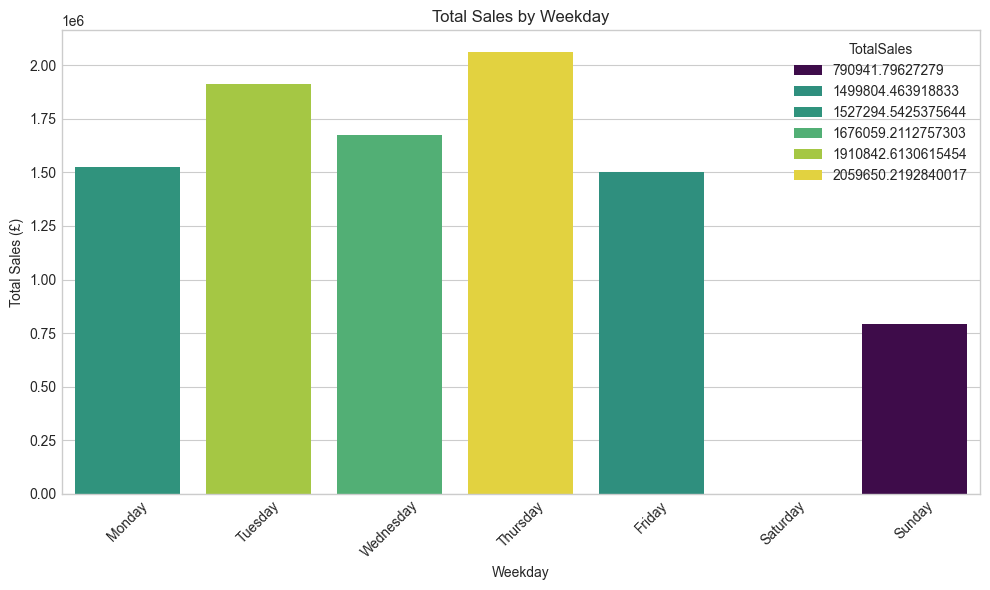

In [64]:
# Group by weekday and calculate total sales
weekday_sales = df.groupby('Weekday', observed=True)['TotalSales'].sum().reset_index()

# Order weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales['Weekday'] = pd.Categorical(weekday_sales['Weekday'], categories=weekday_order, ordered=True)
weekday_sales = weekday_sales.sort_values('Weekday')

plt.figure(figsize=(10,6))
sns.barplot(data=weekday_sales, x='Weekday', y='TotalSales', palette='viridis', hue='TotalSales', dodge=False)
plt.title('Total Sales by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Total Sales (£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

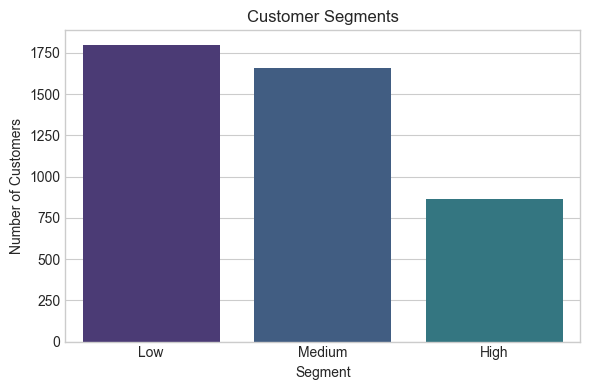

In [65]:
customer_seg = df.groupby('CustomerID', observed=True)['TotalSales'].agg(['sum', 'count']).reset_index()
customer_seg.columns = ['CustomerID', 'TotalSpent', 'PurchaseFrequency']

bins = [0, 500, 2000, np.inf]
labels = ['Low', 'Medium', 'High']
customer_seg['Segment'] = pd.cut(customer_seg['TotalSpent'], bins=bins, labels=labels)

plt.figure(figsize=(6,4))
sns.countplot(data=customer_seg, x='Segment', hue='Segment', legend=False)
plt.title('Customer Segments')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()


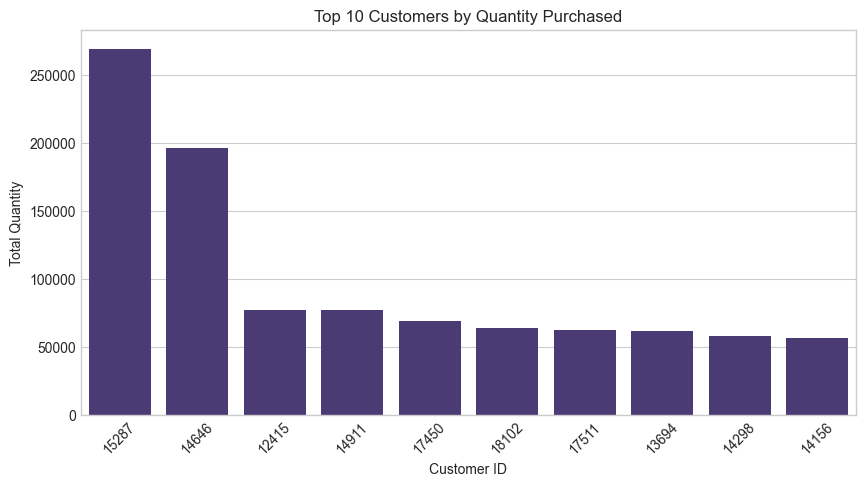

In [66]:
df['CustomerID'] = df['CustomerID'].astype(str)
customer_sales = df.groupby('CustomerID')['Quantity'].sum()
top_customers = customer_sales.sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_customers.index, y=top_customers.values)
plt.xticks(rotation=45)
plt.title('Top 10 Customers by Quantity Purchased')
plt.xlabel('Customer ID')
plt.ylabel('Total Quantity')
plt.show()

In [ ]:
customer_spend = df.groupby('CustomerID')['TotalSales'].sum()

# Sort the customers by total spend in descending order
top_10_customers = customer_spend.sort_values(ascending=False).head(10)

top_10_df = top_10_customers.reset_index()
top_10_df.columns = ['CustomerID', 'TotalSales']

# Plot
fig = px.bar(
    top_10_df,
    x='CustomerID',
    y='TotalSales',
    text='TotalSales',
    title='Top 10 Customers by Total Spend',
    labels={'CustomerID':'Customer ID', 'TotalSales':'Total Spend (£)'}
)

# Format layout
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')  # show 1.2M style
fig.update_yaxes(tickformat=".2s")  # short format on y-axis (e.g. 1.2M, 278K)
fig.update_layout(
    xaxis_tickangle=-45,
    title_x=0.5,
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    plot_bgcolor='white'
)

fig.write_html("..\\reports\\Top_10_Customers_by_Total_Spend.html")


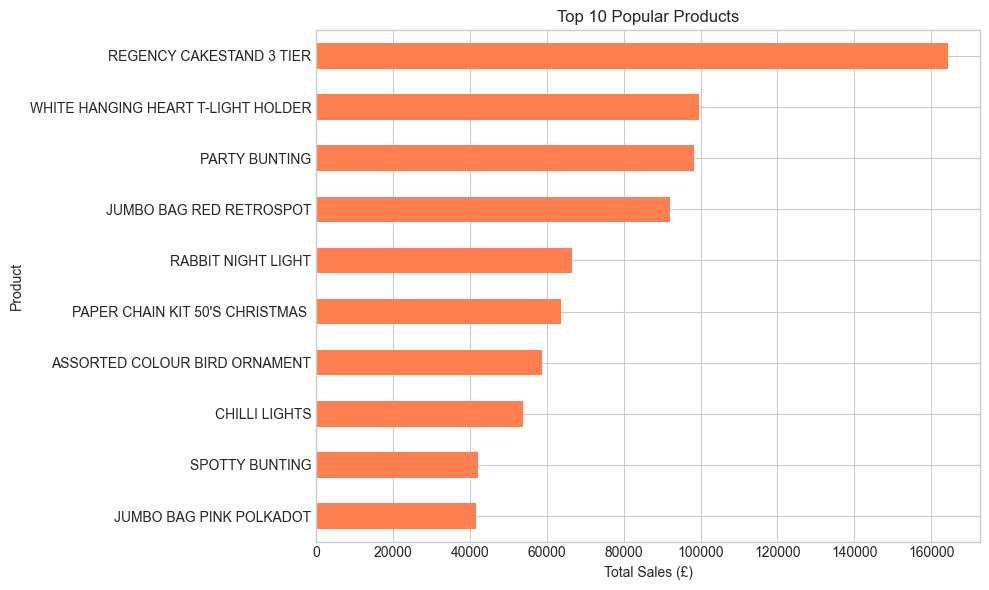

In [71]:
top_products = (df.groupby('Description', observed=True)['TotalSales']
                  .sum()
                  .sort_values(ascending=False)
                  .head(10))


plt.figure(figsize=(10,6))
top_products.plot(kind='barh', color='coral')
plt.xlabel('Total Sales (£)')
plt.ylabel('Product')
plt.title('Top 10 Popular Products')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
